# Breakout Candidates - Defensemen

The objective of this notebook is to identify undervalued NHL defensemen who are early in their careers and poised to breakout next season.

In [1]:
from common import *
import statsmodels.api as sm

In [2]:
# Choose position to filter down to
POSITION = "defensemen"

# Load player historical season stats and salary cap data
hdf = load_historical_stats(POSITION)
hdf = hdf[hdf["season"] == "20242025"]
cdf = load_cap_data()

Join the two datasets on player name, which is not ideal but ok for now.

Also, I did not ingest cap data for all players (e.g. players on IR/LTIR).

And some players have names spelled differently across the two datasets, so they are not joined.

Filtering these cases out for now.

In [3]:
df = hdf.merge(cdf, on="playerName", how="left")
df = df[~df["capHit"].isna()]

Lets check the distribution of average time on ice. Not really using the results of this graph anywhere, but just wanted to check the distribution of this feature.

Hypothesis: Players with low average time on ice (but strong scoring stats) are good breakout candidates.

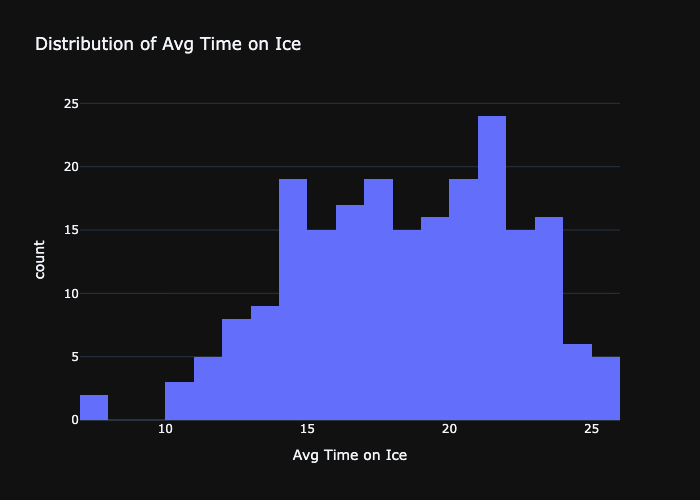

In [5]:
px.histogram(
    df,
    x="avgToi",
    width=800,
    height=500,
    title="Distribution of Avg Time on Ice",
    labels={"avgToi": "Avg Time on Ice"},
)

Lets filter down to players with 1-2 years of experience in the NHL who played at least 10 games this past season. Looks like there are 20 players who fit the bill.

In [24]:
MIN_GAMES = 10
subset = df[
    (df["yoe"] <= 2)
    & (df["gamesPlayed"] >= MIN_GAMES)
    & (df["capHit"] <= 10000000) # Adding this filter bc Elias Pettersson the forward shows up here...
    # & (df["avgToi"] <= 12)
    # & (df["age"] <= 25)
]
subset.shape

(20, 27)

The below text is copy-pasted from my forward breakout candidates ontebook, but leaving it in for now:

Curious what goal/assist/point scoring rates are for these players vs their average ice time.

Lets also adjust for avgToi. The x/60 metric looks at x metric divided by total ice time. But dividing by avgToi gives us more info.

For example, Player A and Player B may both have 0.5 g/60. Lets say both Player A and Player B have 5 goals for a total of 600 min played. Howver, Player A may have 60 games played for an avgToi of 10 minutes per game, while Player B has 30 games played for an avgToi of 20 minutes per game. They both scored the same amount of goals in the same amount of total ice time. However, my interpretation is that Player B was given more slack by the coach (20 minutes per game instead of just 10) while Player A had much less room for error. The difference in number of games could be due to injury or AHL call-ups. If two players have the same per/60 stats, I want to rank players who had less room for error higher than players who had more room for error. This is because I want to idenitfy players who could post increased stats (i.e. breakout) if they are given more ice time. Young players who can deliver under scrutiny and limited ice time are should be well-positioned to blossom given more leeway.

Thus, I divide the metrics by avgToi to create an adjusted metric. I then produce a ranking of the players based on that specific adjusted metric. I will do this for all metrics and then add up the rankings per player. The players with the lowest rank sums, should be the best all around scorer within the criteria of this subset of players adjusted for ice time.

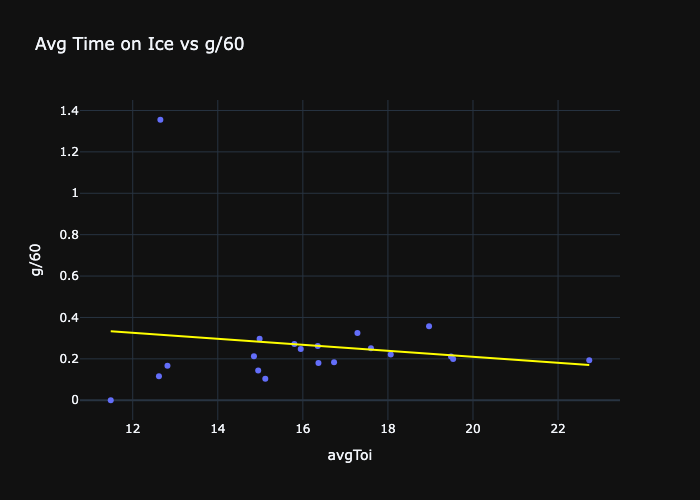

In [23]:
metric = "g/60"
fig = px.scatter(
    subset,
    x="avgToi",
    y=metric,
    hover_name="playerName",
    hover_data=["goals", "assists", "points", "gamesPlayed", "team", "age", "capHit"],
    width=800,
    height=500,
    title=f"Avg Time on Ice vs {metric}",
    trendline="ols",
    trendline_color_override="yellow",
)
fig.show()
subset.loc[:, f"{metric}_adj"] = subset[metric] / subset["avgToi"]
subset.loc[:, f"{metric}_adj_rank"] = subset[f"{metric}_adj"].rank(ascending=False, method='first').astype(int)

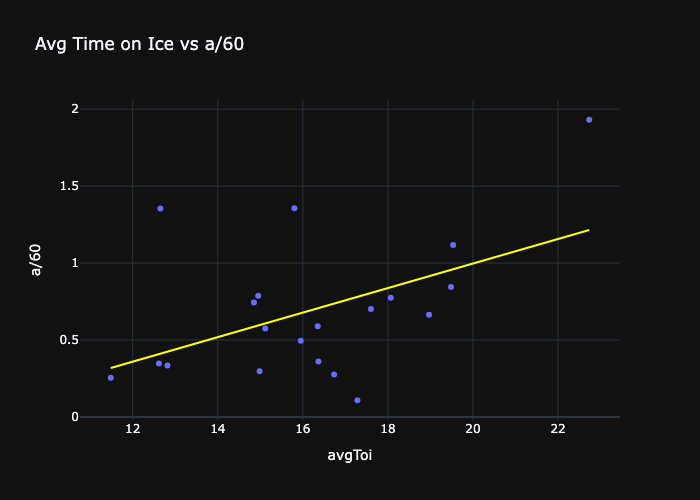

In [22]:
metric = "a/60"
fig = px.scatter(
    subset,
    x="avgToi",
    y=metric,
    hover_name="playerName",
    hover_data=["goals", "assists", "points", "gamesPlayed", "team", "age", "capHit"],
    width=800,
    height=500,
    title=f"Avg Time on Ice vs {metric}",
    trendline="ols",
    trendline_color_override="yellow",
)
fig.show()
subset.loc[:, f"{metric}_adj"] = subset[metric] / subset["avgToi"]
subset.loc[:, f"{metric}_adj_rank"] = subset[f"{metric}_adj"].rank(ascending=False, method='first').astype(int)

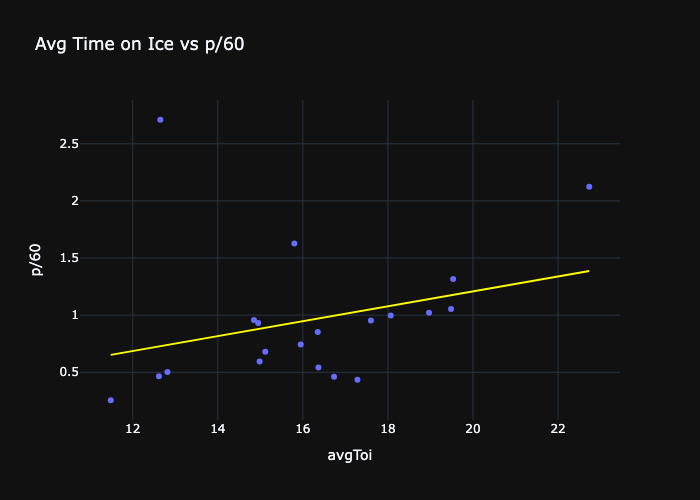

In [20]:
metric = "p/60"
fig = px.scatter(
    subset,
    x="avgToi",
    y=metric,
    hover_name="playerName",
    hover_data=["goals", "assists", "points", "gamesPlayed", "team", "age", "capHit"],
    width=800,
    height=500,
    title=f"Avg Time on Ice vs {metric}",
    trendline="ols",
    trendline_color_override="yellow",
)
fig.show()
subset.loc[:, f"{metric}_adj"] = subset[metric] / subset["avgToi"]
subset.loc[:, f"{metric}_adj_rank"] = subset[f"{metric}_adj"].rank(ascending=False, method='first').astype(int)

Now that I have the three adjusted metrics for goals/assists/points and their respective rankings, I will create the rank_sum metric by adding up the three rankings.

Sorting by this rank sum in ascending order, we see some well-known rising stars in the NHL such as Lane Hutson. He already gets a relatively high amount of ice time, so even after adjusting for ice time he performs well.

Some players towards the top of the list who have relatively low ice time include Seamus Casey, Scot Morrow (Ranger alert!!!), and Uvis Balinskis. These are some of the players I plan to include in my breakout candidates lineup.

In [19]:
subset.loc[:, "rank_sum"] = subset["g/60_adj_rank"] + subset["a/60_adj_rank"] + subset["p/60_adj_rank"]
subset.sort_values("rank_sum")[["rank_sum", "playerName", "team", "gamesPlayed", "goals", "assists", "points", "avgToi", "g/60_adj_rank", "a/60_adj_rank", "p/60_adj_rank"]]

,rank_sum,playerName,team,gamesPlayed,goals,assists,points,avgToi,g/60_adj_rank,a/60_adj_rank,p/60_adj_rank
250,3,Seamus Casey,[New Jersey Devils],14.0,4,4,8,12.650000,1,1,1
240,9,Scott Morrow,[Carolina Hurricanes],14.0,1,5,6,15.800000,5,2,2
259,19,Uvis Balinskis,[Florida Panthers],76.0,4,14,18,14.850000,8,6,5
236,23,Mason Lohrei,[Boston Bruins],77.0,5,28,33,19.533333,15,4,4
251,24,Lane Hutson,[Montréal Canadiens],82.0,6,60,66,22.733333,18,3,3
245,25,Olen Zellweger,[Anaheim Ducks],62.0,7,13,20,18.966667,3,12,10
229,26,Shakir Mukhamadullin,[San Jose Sharks],30.0,2,7,9,18.066667,11,8,7
213,27,Jayden Struble,[Montréal Canadiens],56.0,2,11,13,14.950000,16,5,6
252,27,Pavel Mintyukov,[Anaheim Ducks],68.0,5,14,19,17.600000,9,9,9
208,28,Drew Helleson,[Anaheim Ducks],56.0,4,9,13,16.350000,6,11,11


One more plot for fun here, I have avgToi on the x-axis and rank_sum on the y-axis. Players below the trendline are those that are ranked above average compared to their peers in this subset with similar avgToi. Those in the bottom left section of the graph should be ideal breakout candidates.

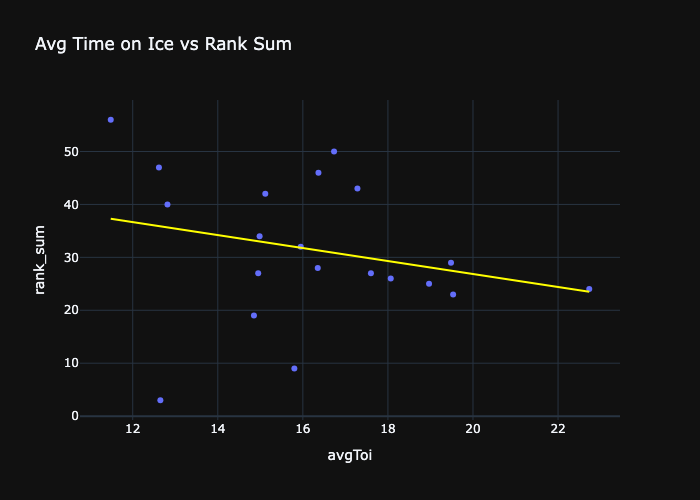

In [15]:
fig = px.scatter(
    subset,
    x="avgToi",
    y="rank_sum",
    hover_name="playerName",
    hover_data=["goals", "assists", "points", "gamesPlayed", "team", "age", "capHit"],
    width=800,
    height=500,
    title=f"Avg Time on Ice vs Rank Sum",
    trendline="ols",
    trendline_color_override="yellow",
)
fig.show()

### Appendix

In [18]:
# # Just looking at goals/60 now, and split by years of experience.
# fig = px.violin(
#     subset,
#     x="yoe",
#     y="p/60",
#     points="all",
#     hover_name="playerName",
#     hover_data=["goals", "assists", "points", "gamesPlayed", "team", "age", "capHit"]
# )
# fig.show()

In [116]:
os.system("jupyter nbconvert --to html breakout-candidates.ipynb")

[NbConvertApp] Converting notebook breakout-candidates.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 5 image(s).
[NbConvertApp] Writing 532122 bytes to breakout-candidates.html


0